In [18]:
import EFIE_solver_2D as efie
import geometry_2D as gm
import numpy as np
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12
frequency = 1e6 * 146
omega = 2 * np.pi * frequency
incident_voltage = 10
radius = 3.175e-3

class antenna:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

wavelength = light_speed / frequency
delta_r = wavelength / 1e2 #! delta_r > wavelength / 1e2 is fck kidding 

n_x, n_y = 9, 3
pos, length, radii, angle, source = [], np.full(n_x * n_y, wavelength/2), np.full(n_x * n_y, 3.175e-3), np.full(n_x * n_y, np.pi/2), np.array([[0.0, 0.0], [0.0, 0.75*wavelength], [0.0, -0.75*wavelength]])
for i in range(n_y):
    for j in range(n_x):
        y_ij = 0.75 * wavelength * (i - int(n_y/2))
        x_ij = 0.25 * wavelength * (j - int(n_x/2))
        pos.append([x_ij, y_ij])    
pos = np.array(pos)
test = antenna(pos, angle, length, source, radii)


In [15]:
polychain = np.array([[0.0, 0.0], [wavelength/4, 0.0], [0.0, wavelength/4], [-wavelength/4, 0.0], [0.0, -wavelength/4], [wavelength/4, -wavelength/4]])
source = np.array([[wavelength/8, 0.0]])

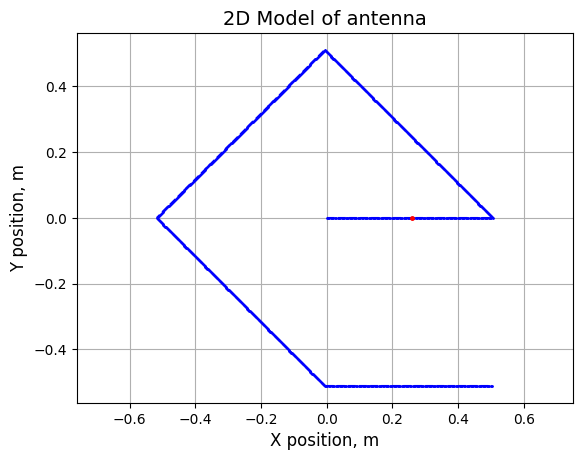

In [16]:
R_block, R = gm.calculate_positions(antenna=polychain, structure_type='polygonal chain', delta_r=delta_r)
gm.plot_antenna(R_block=R_block, R=R, antenna=test, delta_r=delta_r)

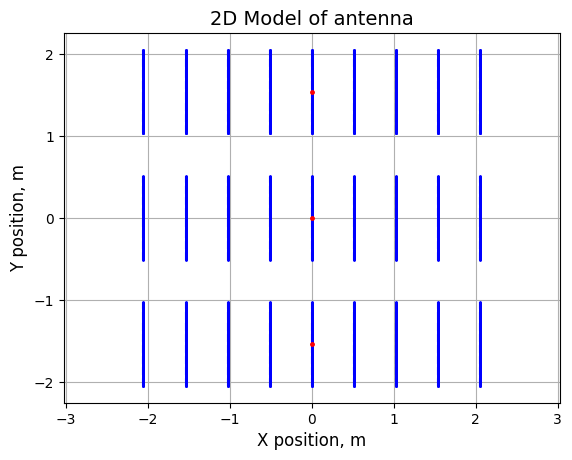

In [2]:
R_block, R = gm.calculate_positions(antenna=test, structure_type='antenna', delta_r=delta_r)
gm.plot_antenna(R_block=R_block, R=R, antenna=test, delta_r=delta_r)

100%|██████████| 5/5 [20:57<00:00, 251.60s/it]


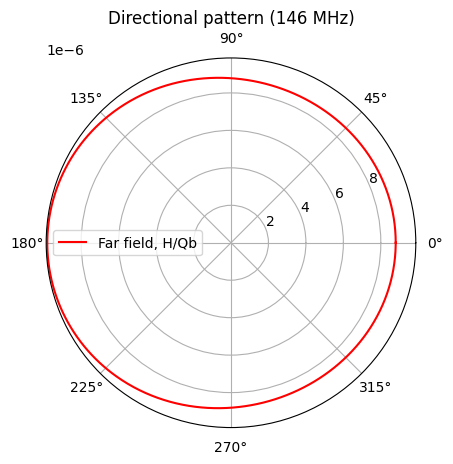

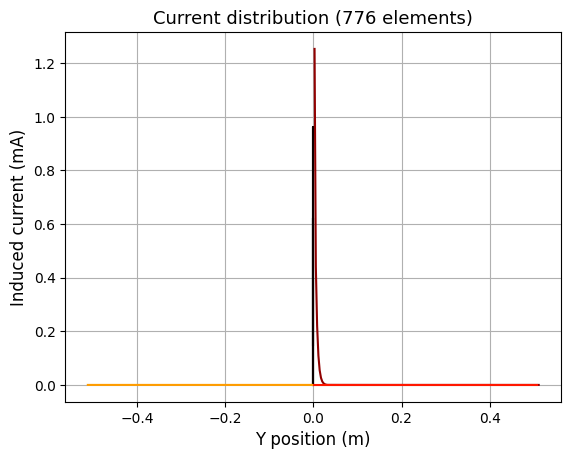

In [17]:
rad = np.full(len(polychain)-1, radius)
ang = np.zeros(len(polychain)-1)
for i in range(len(polychain)-1):
    dy = polychain[i+1, 1] - polychain[i, 1]
    dx = polychain[i+1, 0] - polychain[i, 0]
    ang[i] = np.arctan2(dy, dx)
current = efie.calculate_currents(R_block=R_block, angles=ang, radii=rad, source_positions=test.source_position, incident_field=incident_voltage, frequency=frequency, delta_r=delta_r)
E_total, angles = efie.directional_pattern(current=current, R=R, delta_r=delta_r, frequency=frequency)
gm.dp(E_total, angles)
gm.current_disribution_together(R_block, current)
gm.current_distribution_2d(R, current)

In [ ]:
import numpy as np
import pyswarms as ps
import geometry_2D as gm
import EFIE_solver_2D as efie
import matplotlib.pyplot as plt 
import numpy as np

class antenna:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

light_speed, mu0, eps0, incident_field, frequency = 299792458., 4*np.pi*1e-7, 8.854e-12, 10, 1e6 * 146
omega = 2 * np.pi * frequency
radius = 3.175e-3
source_positions = np.array([[0.0, 0.0]])
delta_r = light_speed / frequency / 5e2

k_form, k_max, k_side = 1, 1, 1
E_0 = 0.5

phi = np.linspace(0, 2*np.pi, 1000)
aim_func = np.zeros(len(phi))
for i in range(len(phi)): aim_func[i] = max(0,np.sin(np.pi/2-phi[i]))**7 

def graph_to_antenna(graph, structure_type):
    center_positions, angles, lengths, radii = np.zeros((len(graph)-1,2)), np.zeros(len(graph)-1), np.zeros(len(graph)-1), np.zeros(len(graph)-1)
    source = graph[0]
    if structure_type == 'polygonal chain':
        for i in range (len(graph)-1):
            center_positions[i] = (graph[i] + graph[i+1]) / 2
            dy = graph[i+1, 1] - graph[i, 1]
            dx = graph[i+1, 0] - graph[i, 0]
            angles[i] = np.arctan2(dy, dx)
            lengths[i] = np.linalg.norm(graph[i+1] - graph[i])
            radii[i] = radius
    ans = antenna(center_positions, angles, lengths, source, radii)
    return ans
        
def check_self_intersection(points):
    def orientation(p, q, r):
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2
    def on_segment(p, q, r):
        return (min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and
                min(p[1], r[1]) <= q[1] <= max(p[1], r[1]))
    def segments_intersect(p1, q1, p2, q2):
        o1 = orientation(p1, q1, p2)
        o2 = orientation(p1, q1, q2)
        o3 = orientation(p2, q2, p1)
        o4 = orientation(p2, q2, q1)
        if o1 != o2 and o3 != o4:
            return True
        if o1 == 0 and on_segment(p1, p2, q1):
            return True
        if o2 == 0 and on_segment(p1, q2, q1):
            return True
        if o3 == 0 and on_segment(p2, p1, q2):
            return True
        if o4 == 0 and on_segment(p2, q1, q2):
            return True
        return False
    n = len(points)
    if n < 4:
        return False  
    for i in range(n - 1):
        for j in range(i + 2, n - 1):
            if segments_intersect(points[i], points[i+1], points[j], points[j+1]):
                return True
    return False


def fit_form (E_total):
    if np.abs(np.max(E_total)) <= 1e-9:
        return 1e9
    return np.clip(1 - np.dot(E_total/np.max(E_total),aim_func)/np.linalg.norm(aim_func)/np.linalg.norm(E_total/np.max(E_total)),0, 1e9)

def fit_max (E_total):
    return np.clip(np.exp(1 - E_total[0]/E_0) - 1, 0, 1e9)

def fit_side (E_total):
    if np.abs(E_total[0]) <= 1e-9:
        return 1e9
    return np.clip(np.exp(np.max(E_total[int(len(phi)/4):int(len(phi)*3/4)])/E_total[0]) - 1, 0, 1e9)

def my_objective_function(solution):
    fit = np.zeros(len(solution))
    for s in range(len(fit)):
        graph = np.concatenate(([[0.0,0.0]], solution[s].reshape(vertex_num, 2)))
        if structure_type == 'polygonal chain':
            if check_self_intersection(points=graph):
                fit[s] = 1e9
            else :
                antenna = graph_to_antenna(graph, structure_type)
                R_block, R = gm.calculate_positions(graph, structure_type, delta_r)
                print(len(R), 'segments of MoM')
                current = efie.calculate_currents(R_block=R_block, angles=antenna.angle, radii=antenna.radius, source_positions=antenna.source_position, incident_field=incident_field, frequency=frequency, delta_r=delta_r)
                E_total, angles = efie.directional_pattern(current, R, delta_r, frequency)
                plt.polar(angles,E_total)
                fit[s] = k_form * fit_form(E_total) + k_side * fit_side(E_total) + k_max * fit_max(E_total)
                data_currents.append(current)
                data_positions.append(R)
    return fit

data_currents = []
data_positions = []

options = {
    'c1': 1.4,  
    'c2': 0.9,  
    'w': 0.8  
}

structure_type = 'polygonal chain'
vertex_num = 4
dimensions = vertex_num * 2
n_particles = 10
wavelength = light_speed / frequency
iters = 10

low_bound = -wavelength
up_bound = wavelength
lower_bounds = np.full(dimensions, low_bound)
upper_bounds = np.full(dimensions, up_bound)
bounds = (lower_bounds, upper_bounds)

optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)
best_cost, best_pos = optimizer.optimize(my_objective_function, iters=iters)

print("Лучшее сходство:", best_cost)
print("Лучшее решение:", best_pos)

np.savez(
    f'data_{structure_type.replace(" ", "_")}_{vertex_num}vertices.npz',
    opt=np.array([best_pos, best_cost], dtype=object),
    params=np.array([options["c1"], options["c2"], options["w"], n_particles, iters], dtype=object),
    current=np.array(data_currents, dtype=object),
    position=np.array(data_positions, dtype=object),
    allow_pickle=True
)

2025-04-14 00:35:46,963 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.4, 'c2': 0.9, 'w': 0.8}
pyswarms.single.global_best:   0%|          |0/10

1607 segments of MoM


c:\Users\lukas\OneDrive\Документы\Method-of-moment-for-antennas\MyMomVenv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\lukas\OneDrive\Документы\Method-of-moment-for-antennas\MyMomVenv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning:

The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.

100%|██████████| 4/4 [46:09<00:00, 692.46s/it]


1883 segments of MoM


100%|██████████| 4/4 [12:09<00:00, 182.44s/it]


2386 segments of MoM


c:\Users\lukas\OneDrive\Документы\Method-of-moment-for-antennas\MyMomVenv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

100%|██████████| 4/4 [2:40:20<00:00, 2405.18s/it]


2295 segments of MoM


100%|██████████| 4/4 [09:28<00:00, 142.20s/it]


1236 segments of MoM


100%|██████████| 4/4 [07:34<00:00, 113.59s/it]


1532 segments of MoM


100%|██████████| 4/4 [06:14<00:00, 93.50s/it]


1838 segments of MoM


100%|██████████| 4/4 [08:27<00:00, 126.92s/it]


1917 segments of MoM


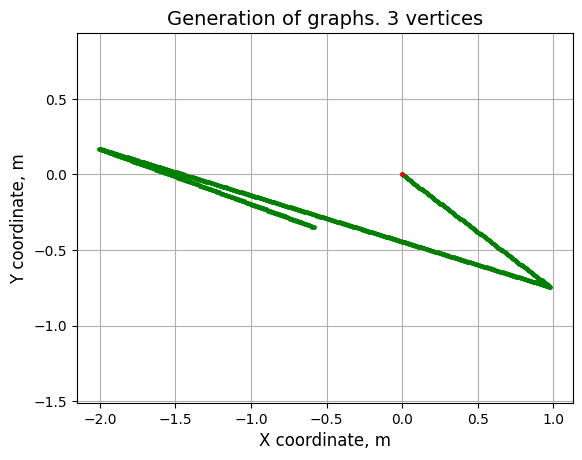

In [2]:

import numpy as np
import matplotlib.pyplot as plt
colors = ['green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'black']

data = np.load('data_polygonal_chain_3vertices.npz', allow_pickle=True)

r = data['position']
cur = data['current']
opt = data['opt']
plt.scatter(0.0, 0.0, s=6, zorder=20, color = 'red')
for i in range(len(r)):
    xi_coords = [pair[0] for pair in r[i]]
    yi_coords = [pair[1] for pair in r[i]]
    plt.scatter(xi_coords, yi_coords, s=6, zorder=10, color = colors[i % len(colors)], label = f'Antenna №{i+1}, {len(r[i])}')
    plt.title(f'Generation of graphs. {3} vertices', size = 14)
    # plt.legend()
    plt.axis('equal')
    plt.xlabel('X coordinate, m', size = 12)
    plt.ylabel('Y coordinate, m', size = 12)
plt.grid(True, zorder = 0)
plt.show()

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import colormaps as cmaps
from matplotlib import colormaps as plt_cmaps
import plotly.graph_objects as go

light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

def current_distribution_2d (R, current):

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=R[:,0],
        y=R[:,1] ,
        mode='markers',
        marker=dict(
            size=10,
            color=np.abs(current),
            colorscale='plasma',
            showscale=True,
            colorbar=dict(title='Amplitude of current, A')
        ),
        name='Точки'
    ))
    fig.update_layout(
        title='Induced current distribution',
        xaxis_title='Y position, m',
        yaxis_title='Z position, m',
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x")
    )
    fig.show()
current_distribution_2d(r[0], cur[0])